The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

# Summary of Findings

### Introduction
- There is an outages dataset with region, timing, causality... etc.

### Cleaning and EDA
Cleaning: 
- First, we removed the row 'units' and put it into a dictionary with keys being the column title and the value as the corresponding unit. We removed the the units row completely from the dataframe. Then, we removed the rows and columns with completely empty values then set the column name to the appropriate title. There were two main columns (CUSTOMERS.AFFECTED, OUTAGE.DURATION) we were considering when considering EDA and hypothesis test, so we imputed the null values assuming NERC.REGION is MAR for both columns (because regional facilities are most likely a factor on how many people in that region is affected and how long the outage is solved.) with the grouped mean. Later, we combined date and time columns into one and dropped the excess. 

EDA
- While we were exploring the columns of the data we found a really interesting statistic that one category was dominating one column more than the other categories within that column and then we decided to look more into what were the differences between this category than the others on what kind of outages were being caused. However, we changed the topics a bit to include more of the data so we compared the causes of outages with the type of outages they were causing, the regular outages and our criteria of more severe outages.

### Assessment of Missingness
- First, we determine the NMAR of the columns we chose. To see the missingness of columns, we took two categorical columns with non trivial missing values and utilized TVDS permutation test to determine the conditonality. Took column OUTAGE.RESTORATION compared to CUSTOMER.GROUP(self created) to see its missingness, we found that it is not conditional. Took column CLIMATE.CATEGORY compared to CAUSE.CATEGORY to see its missingness, we found that it is conditional.

### Hypothesis Test

- For our null hypothesis, we said that CAUSE.CATEGORY did not have a direct affect on whether or not a more severe outage would occur. While the alternate hypothesis, was that CAUSE.CATEGORY did have a direct affect on whether or not a more severe outage would occur. We tested this by calculating the TVD of the CAUSE.CATEGORY, since it is a categorical variable, with whether the outage is severe or not. In the end, we rejected the null hypothesis the p-value basically stated that it is impossible to get the observed test statistic.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

from scipy.stats import ks_2samp

### Cleaning

In [21]:
outages = pd.read_excel('outage.xlsx')

In units, I pulled out the unit of each column title, so if you have any question on what the unit of each column is,
type in the name of the column into the key of dictionary and the value will tell you

In [22]:
#Getting units for each column
units = {k:v for (k,v) in zip(outages.iloc[4].values, outages.iloc[5].values)}

In the cell below, I dropped the rows and columns with no values and set the column title with appropriate row. In the EDA and our hypothesis test we will have specific concern over the column CUSTOMERS.AFFECTED and OUTAGE.DURATION, so we filled the nan value with relevant numbers.

In [23]:
#Cleaning of the data
outages.columns = outages.iloc[4].values # setting column name to the correct row
outages_cleaned = outages.drop([0,1,2,3,4,5]) #dropped empty rows that holds no value or data
outages_cleaned = outages_cleaned.reset_index(drop = True) #resetting index for clarity

#dropping column with number of observations and 'variables that holds no meaning as a column
outages_cleaned = outages_cleaned.drop(columns = ['OBS','variables']) 

# fillna CUSTOMERS.AFFECTED with mean of grouped NER.REGION mean due to MAR between two columns
outages_cleaned['CUSTOMERS.AFFECTED'] = outages_cleaned['CUSTOMERS.AFFECTED'].astype(float)
region_grouped_cust_mean = outages_cleaned.groupby('NERC.REGION')['CUSTOMERS.AFFECTED'].transform(np.mean)
outages_cleaned['CUSTOMERS.AFFECTED'] = outages_cleaned['CUSTOMERS.AFFECTED'].fillna(region_grouped_cust_mean)

# fillna OUTAGE.DURATION with mean of grouped NER.REGION mean due to MAR between two columns
outages_cleaned['OUTAGE.DURATION'] = outages_cleaned['OUTAGE.DURATION'].fillna(-1)
outages_cleaned['OUTAGE.DURATION'] = outages_cleaned['OUTAGE.DURATION'].astype(float)
region_grouped_rest_dur_mean = outages_cleaned.groupby('NERC.REGION')['OUTAGE.DURATION'].transform(np.mean)
outages_cleaned['OUTAGE.DURATION'] = outages_cleaned['OUTAGE.DURATION'].fillna(region_grouped_rest_dur_mean)


Created a combine_date_time as a helper to merge the date and time columns from OUTAGE.START and OUTAGE.RESTORATION

In [24]:
def combine_date_time(df, date, time):
    """ A helper function used to combine date and time through
    the use of apply
    """
    if not pd.isnull(df[date]) and not pd.isnull(df[time]):
        return datetime.strptime((str(df[date])[:-8] + str(df[time])), '%Y-%m-%d %H:%M:%S')

In [25]:
#applying the helper function to combine date and time
outages_cleaned['OUTAGE.START'] = outages_cleaned.apply(combine_date_time, args =('OUTAGE.START.DATE', 'OUTAGE.START.TIME'), axis = 1)
outages_cleaned['OUTAGE.RESTORATION'] = outages_cleaned.apply(combine_date_time, args =('OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'), axis = 1)

#dropping date and time column because we have them combined already
outages_cleaned = outages_cleaned.drop(columns = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME','OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])
outages_cleaned.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2015-07-18 02:00:00,2015-07-19 07:00:00


### EDA

Helper function for our new column severe_outage that includes more than 1000 people affected and more than 60 minutes during the power outage

In [26]:
def severe_outage(df):
    if (df["CUSTOMERS.AFFECTED"] >= 1000):
        if (df["OUTAGE.DURATION"] >= 60):
            if (df['OUTAGE.RESTORATION'] - df['OUTAGE.START']) > timedelta(1):
                return True
    else:
        return False

In [31]:
outages_cleaned["SEVERE_OUTAGE"] = outages_cleaned.apply(severe_outage, axis = 1)
outages_cleaned.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION,SEVERE_OUTAGE
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2011-07-01 17:00:00,2011-07-03 20:00:00,True
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2014-05-11 18:38:00,2014-05-11 18:39:00,None
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2010-10-26 20:00:00,2010-10-28 22:00:00,True
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2012-06-19 04:30:00,2012-06-20 23:00:00,True
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2015-07-18 02:00:00,2015-07-19 07:00:00,True


In [32]:
outages_cleaned["SEVERE_OUTAGE"] = outages_cleaned["SEVERE_OUTAGE"].replace({None:False})

Interesting Aggregates(For the Interesting Aggregates, while we were exploring our data we discovered that some categories had a higher chance of being a more severe outage than others, so in order to prove that we created a whole new set of criteria for how a severe outage is and in that process we discovered a vast amount of one CAUSE.CATEGORY creating more severe outages than the others,and decided to explore more into this statistic)

In [35]:
#Interesting Aggregates
distr = outages_cleaned.pivot_table(index = 'CAUSE.CATEGORY', values = 'SEVERE_OUTAGE', aggfunc = 'sum')
display(distr)

,SEVERE_OUTAGE
CAUSE.CATEGORY,
equipment failure,2.0
fuel supply emergency,20.0
intentional attack,18.0
islanding,0.0
public appeal,16.0
severe weather,466.0
system operability disruption,15.0


Bivariate Analysis(For the Bivariate Analysis, we dove deeper into the interesting aggregates took the data of all the outages and found the number of times each CAUSE.CATEGORY appeared and divided it with the CAUSE.CATEGORY for the outages that we classified as severe outages, and that gives us each time a CAUSE.CATEGORY appears what is the percent chance it will be a severe outage)

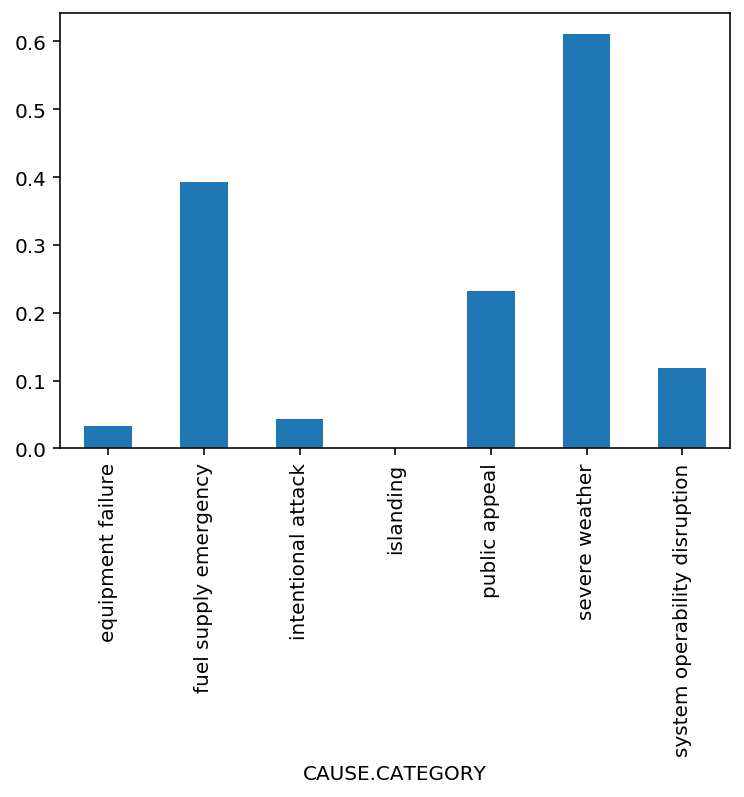

In [39]:
#Bivariate Analysis
(distr['SEVERE_OUTAGE']/outages_cleaned['CAUSE.CATEGORY'].value_counts().sort_index()).plot(kind = 'bar')

Univariate Analysis(Our Univariate analysis, shows that of all the causes of outages that severe weather is what caused the most outages, we choose to go deeper into what is the difference between the types of outages caused by the different categories and see if there are any major differences)

In [40]:
#Univariate Analysis
outages_cleaned['CAUSE.CATEGORY'].describe()

count               1534
unique                 7
top       severe weather
freq                 763
Name: CAUSE.CATEGORY, dtype: object

### Assessment of Missingness

The two columns we considered: CUSTOMER.GROUP and CLIMATE.CATEGORY. For CUSTOMER.GROUP, it will not have any missing values becuase it is a column we created from CUSTOMERS.AFFECTED. In CUSTOMERS.AFFECTED we imputed the value with the grouped mean. It will not be NMAR. For CLIMATE.CATEGORY, it is possible the value is NMAR because the data creator did not know the temperature, but that argument is not convincing, so we performed and the permutation test and discovered it is dependent on other column.

Is the missingness of RESTORATION.TIME is conditional to CUSTOMER.GROUP? (Not Dependent)

CUSTOMER.GROUP is a column of Boolean values that has 'greater' for the amount of people affected from power outage greater or equal to 1000, 'lesser' for those who have less than 1000 affected people

In [41]:
#creating a new column of two groups that have greater or less than 1000 affected people
outages_cleaned['CUSTOMER.GROUP'] = (outages_cleaned['CUSTOMERS.AFFECTED'] >= 1000).replace(True, 'greater').replace(False, 'lesser')
outages_cleaned = outages_cleaned.assign(is_null = outages_cleaned['OUTAGE.RESTORATION'].isnull())

#find observed tvd between OUTAGE.RESTORATION's missingness and CUSTOMER.GROUP
emp_distributions = outages_cleaned.pivot_table(columns = 'is_null', index = 'CUSTOMER.GROUP', aggfunc = 'size').fillna(0).apply(lambda x: x/x.sum())
observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1).iloc[:,-1])) /2
observed_tvd

0.03450612092327819

Perform tvds permutation test because CUSTOMER.GROUP is a categorical data with counts of True and False as values

In [42]:
#tvds permutation test of 1000 times
n_repetitions = 1000

# ks_list = []
tvds = []
for _ in range(n_repetitions):
    
    # shuffle the gender column
    shuffled_col = (
        outages_cleaned['CUSTOMER.GROUP']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        outages_cleaned
        .assign(**{
            'shuff': shuffled_col,
        })
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='is_null', index='shuff', values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

In [43]:
pval = np.mean(pd.Series(tvds) >= observed_tvd)
pval

0.584

At 5 percent test statistic. No, the missingness of RESTORATION.TIME is not conditional to CUSTOMER.GROUP. We observed the pval to be above 5 percent.

____________________________________________________________________________________

Is the missingness of CLIMATE.CATEGORY conditional to CAUSE.CATEGORY? (Dependent)

In [44]:
#created a column CLIMATE.CATEGORY_ISNULL to see the obeserved tvd of CLIMATE.CATEGORY's missingness
#in conjunction of CAUSE.CATEGORY
outages_cleaned['CLIMATE.CATEGORY_ISNULL'] = outages_cleaned['CLIMATE.CATEGORY'].isnull()
emp_distributions = outages_cleaned.pivot_table(columns = 'CLIMATE.CATEGORY_ISNULL', index = 'CAUSE.CATEGORY', aggfunc = 'size').fillna(0).apply(lambda x: x/x.sum())

observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1).iloc[:,-1])) /2
observed_tvd

0.40276867030965396

Perform tvds permutation test because CAUSE.CATEGORY is a categorical data with counts of True and False as values

In [45]:
n_repetitions = 1000

tvds = []
for _ in range(n_repetitions):
    
    # shuffle the gender column
    shuffled_col = (
        outages_cleaned['CAUSE.CATEGORY']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        outages_cleaned
        .assign(**{
            'shuff': shuffled_col,
        })
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='CLIMATE.CATEGORY_ISNULL', index='shuff', values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

In [ ]:
pval = np.mean(pd.Series(tvds) >= observed_tvd)
pval

At 5 percent test statistic. Yes, the missingness of CLIMATE.CATEGORY is conditional to CAUSE.CATEGORY. We observed the pval to be below 5 percent.

# Hypothesis Test

Null hypothesis: The proportion of severity(determined by the criteria we set that more than a thousand customers be affected, the outage lasting more than an hour, and the outage start time and outage restoration time be separated by more than an day)is not determined by the CAUSE.CATEGORY.

Alternate hypothesis: The portion of severity(determined by the criteria we set that more than a thousand customers be affected, the outage lasting more than an hour, and the outage start time and outage restoration time be separated by more than an day) is determined to CAUSE.CATEGORY

Test-Statistic: Our test statistic, is the Total Variation Distance statistic, since for our hypothesis required analysis of a categorical variable, since TVD is the best choice for categorical variables we used TVD as our test statistic

Significance level: For our significance level, we choose %5 because anything pass %5 reaches extremeness level therefore making %5 the default for most hypothesis.

P-Value:For our p-value we got 0% after 1000 iterations, this means that it is extremely unlikely to the observed test statistic within the null hypothesis.

Results: With the p-value so low, we reject the null hypothesis.

In [49]:
def tvd_of_groups(df):
    df_copy = df[['SEVERE_OUTAGE', 'CAUSE.CATEGORY']].copy()
    cnts = df_copy.pivot_table(index = 'SEVERE_OUTAGE', columns = 'CAUSE.CATEGORY', aggfunc = 'size').T.fillna(0)
    distr = cnts.apply(lambda x: x/x.sum())
    return distr.diff(axis = 1).iloc[:, -1].abs().sum()/2

In [50]:
obs = tvd_of_groups(outages_cleaned)
obs

0.5760409720782458

0.0

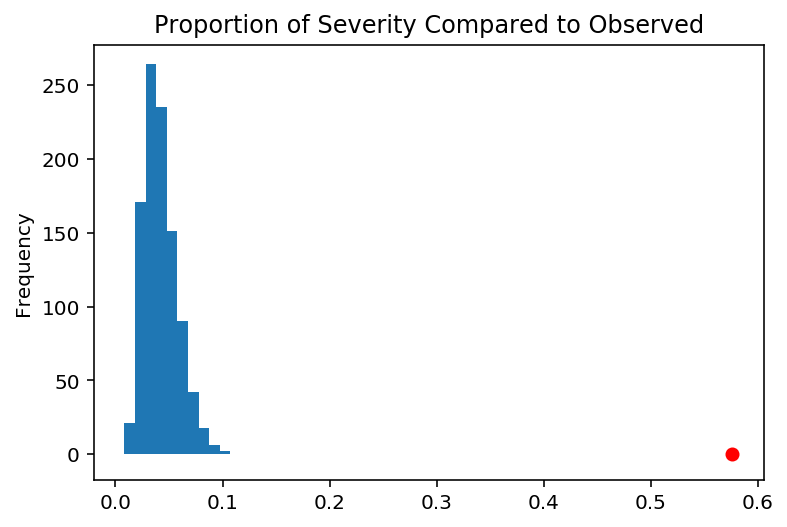

In [52]:
N = 1000
tvds = []
for _ in range(N):
    out = outages_cleaned.copy()
    s = out['SEVERE_OUTAGE'].sample(frac=1, replace=False).reset_index(drop=True)
    shuffled = out.loc[:, ['SEVERE_OUTAGE']].assign(SEVERE_OUTAGE=s)
    out["SEVERE_OUTAGE"] = shuffled 
    tvds.append(tvd_of_groups(out))
pd.Series(tvds).plot(kind = 'hist',title ="Proportion of Severity Compared to Observed")
plt.scatter(obs, 0, color = 'red')

tvds = pd.Series(tvds)
pval = (tvds >= obs).sum() / N
pval

_________________________________________________________________________________________________________________________

### Part 2

# Summary of Findings
- LinearSVC Classification
- Accuracy score

### Introduction
Our group decided to predict the the number of major outages in the year 2020. Since, we do not currently have the data for outages in 2020, we will build and test the model on all the previous years to determine its accuracy.

### Baseline Model
For our baseline model, we decided to take the columns 'Year', 'Month', 'U.S._STATE', 'CAUSE.CATEGORY', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', and 'SEVERE_OUTAGE'. We have 2 ordinal, 2 nominal, and 4 quantitative variables. We had to take Year because since it is required to predict the year 2020. Then Month and U.S._STATE we needed so we could predict the different trends that occur during outages, like the different seasons per months and the different weather that occurs per state. Finally, 'CAUSE.CATEGORY', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', and 'SEVERE_OUTAGE' were also taken so order to help perdict which outages would be major. For our prediction, we one hot encoded the columns 'U.S._STATE' and 'CAUSE.CATEGORY' which are both categorical, and we did this to remove all the categorical values from the data set to get a better prediction. We chose to use LinearSVC classifiers,because LinearSVC fit our nontext model.

### Final Model
For our baseline model, We decided improve the prediction by adding more features, like grouping the month into the seasons in order to find any trends in the outages with the seasons. Another is grouping the causes into category of natural cause and human cause with True or False, which will again find any correlation between the outages and its cause. We also binned the data from the columns 'OUTAGE.DURATION' and "POPULATION" in order to minimize the effect of outlines on the final prediction. Finally, we added Binarizer to the pipeline to cut off at 1000 for "CUSTOMERS.AFFECTED" since that is our cutoff value for evaluating if an outage is major or not. The end result of these improvements is that we improved the baseline prediction by 12% in the final model.

### Fairness Evaluation
For fairness evaluation we seperated the data into two seperate group of before(exclusive) 2012 and after(inclusive) 2012 as observed groups.
- We utlized linearSVC.score as our parity measure because it return the mean accuracy on the given test data and labels
1. We performed the final model on both of the observed and took the difference between two values as observed statistic. (diff_acc_between_two_groups)
2. We shuffled the CUSTOMERS.AFFECTED column for both groups, then we performed the final model on both the groups. Afterward, we took the difference the outputted values. (diff_acc_between_two_groups_shuff)
3. We then observed the p-values by comparing the difference of the observed and shuffled accuracy value.
#### We found the p-value to be 0.22 for 100 iteration, therefore fail to reject null hypothesis of the final model is fair

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import Binarizer

In [55]:
pd.set_option('display.max_columns', None)

### Cleaning

In [56]:
outages = pd.read_excel('outage.xlsx')

In the cell below, I dropped the rows and columns with no values and set the column title with appropriate row.

In [57]:
#Cleaning of the data
outages.columns = outages.iloc[4].values # setting column name to the correct row
outages_cleaned = outages.drop([0,1,2,3,4,5]) #dropped empty rows that holds no value or data
outages_cleaned = outages_cleaned.reset_index(drop = True) #resetting index for clarity

#dropping column with number of observations and 'variables that holds no meaning as a column
outages_cleaned = outages_cleaned.drop(columns = ['OBS','variables']) 

# fillna CUSTOMERS.AFFECTED with mean of grouped NER.REGION mean due to MAR between two columns
outages_cleaned['CUSTOMERS.AFFECTED'] = outages_cleaned['CUSTOMERS.AFFECTED'].astype(float)
region_grouped_cust_mean = outages_cleaned.groupby('NERC.REGION')['CUSTOMERS.AFFECTED'].transform(np.mean)
outages_cleaned['CUSTOMERS.AFFECTED'] = outages_cleaned['CUSTOMERS.AFFECTED'].fillna(region_grouped_cust_mean)

# fillna OUTAGE.DURATION with mean of grouped NER.REGION mean due to MAR between two columns
outages_cleaned['OUTAGE.DURATION'] = outages_cleaned['OUTAGE.DURATION'].astype(float)

We dropped the nan value in OUTAGE.DURATION becuase it would skew the data if we fill it with mean or proportion. We see the proportion of nan value in each state to see if we drop the value it would have a significant effect. We discover the proportion of nan value only represent maxium of less than FIVE precent of the data in each state with the exception of Alaska, where the nan value is presented one hundred percent of the time. We decided it would bemore accurate for the prediction to drop the Nan values instead of filling it.

In [58]:
outages_cleaned[outages_cleaned['OUTAGE.DURATION'].isnull()]['U.S._STATE'].value_counts() / outages_cleaned['U.S._STATE'].value_counts()

Alabama                 0.166667
Alaska                  1.000000
Arizona                 0.107143
Arkansas                     NaN
California              0.057143
Colorado                0.066667
Connecticut                  NaN
Delaware                0.024390
District of Columbia         NaN
Florida                      NaN
Georgia                      NaN
Hawaii                       NaN
Idaho                   0.111111
Illinois                0.043478
Indiana                 0.023256
Iowa                         NaN
Kansas                  0.222222
Kentucky                     NaN
Louisiana               0.050000
Maine                   0.052632
Maryland                     NaN
Massachusetts                NaN
Michigan                     NaN
Minnesota                    NaN
Mississippi                  NaN
Missouri                0.117647
Montana                      NaN
Nebraska                     NaN
Nevada                       NaN
New Hampshire                NaN
New Jersey

In [59]:
outages_cleaned = outages_cleaned[outages_cleaned['OUTAGE.DURATION'].notnull()].reset_index(drop = True)
outages_cleaned = outages_cleaned[outages_cleaned['CUSTOMERS.AFFECTED'].notnull()].reset_index(drop = True)

Helper function for our new column severe_outage that includes more than 1000 people affected and more than 60 minutes during the power outage

In [60]:
def severe_outage(df):
    if (df["CUSTOMERS.AFFECTED"] >= 1000) and (df["OUTAGE.DURATION"] >= 60):
        return True
    else:
        return False

In [61]:
outages_cleaned["SEVERE_OUTAGE"] = outages_cleaned.apply(severe_outage, axis = 1)
outages_cleaned["SEVERE_OUTAGE"] = (outages_cleaned['SEVERE_OUTAGE'] == True)
outages_cleaned['SEVERE_OUTAGE'].value_counts()/len(outages_cleaned)

True     0.717288
False    0.282712
Name: SEVERE_OUTAGE, dtype: float64

### Baseline Model

We dropped any column we deemed as unnecessary and only kept columns we thought would be important in our final predictions

In [62]:
outages_for_model = outages_cleaned[['YEAR', 'MONTH','U.S._STATE','CAUSE.CATEGORY','CUSTOMERS.AFFECTED', 'OUTAGE.DURATION','POPULATION','SEVERE_OUTAGE']]
outages_for_model

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CUSTOMERS.AFFECTED,OUTAGE.DURATION,POPULATION,SEVERE_OUTAGE
0,2011,7,Minnesota,severe weather,70000.000000,3060.0,5348119,True
1,2014,5,Minnesota,intentional attack,88984.965517,1.0,5457125,False
2,2010,10,Minnesota,severe weather,70000.000000,3000.0,5310903,True
3,2012,6,Minnesota,severe weather,68200.000000,2550.0,5380443,True
4,2015,7,Minnesota,severe weather,250000.000000,1740.0,5489594,True
...,...,...,...,...,...,...,...,...
1470,2016,3,Idaho,intentional attack,0.000000,0.0,1680026,False
1471,2016,7,Idaho,system operability disruption,133833.065306,220.0,1680026,True
1472,2011,12,North Dakota,public appeal,34500.000000,720.0,685326,True
1473,2009,8,South Dakota,islanding,127894.232092,59.0,807067,False


We used OneHotEncoder for the baseline inorder to have no categorical variables left in the dataset. So we are predicting just based off of the quantitative data of this dataset.

In [63]:
preproc = ColumnTransformer(transformers=[('encode', OneHotEncoder(handle_unknown = 'ignore'),['U.S._STATE', 'CAUSE.CATEGORY']),
                                         ])
pl = Pipeline(steps = [('preprocessor',preproc), 
                       ('baseline classification', LinearSVC())])

X = outages_for_model.drop(['SEVERE_OUTAGE'], axis = 1)
y = outages_for_model.SEVERE_OUTAGE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pl.fit(X_train, y_train)
pl.predict(X_test).sum()
pl.score(X_test, y_test)

0.8284424379232506

In [64]:
basic_score = []
for i in range(100):
    preproc = ColumnTransformer(transformers=[('encode', OneHotEncoder(handle_unknown = 'ignore'),['U.S._STATE', 'CAUSE.CATEGORY']),
                                             ])

    pl = Pipeline(steps = [('preprocessor',preproc), 
                           ('baseline classification', SVC())])

    X = outages_for_model.drop(['SEVERE_OUTAGE'], axis = 1)
    y = outages_for_model.SEVERE_OUTAGE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pl.fit(X_train, y_train)
    pl.predict(X_test).sum()
    basic_score.append(pl.score(X_test, y_test))

After 100 iterations of the predtictions, we were around 82% most of the time, which is pretty good for just our baseline prediction doing the bare minimum.

In [65]:
np.mean(basic_score)

0.8279006772009029

### Final Model


In [66]:
outages_for_model

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CUSTOMERS.AFFECTED,OUTAGE.DURATION,POPULATION,SEVERE_OUTAGE
0,2011,7,Minnesota,severe weather,70000.000000,3060.0,5348119,True
1,2014,5,Minnesota,intentional attack,88984.965517,1.0,5457125,False
2,2010,10,Minnesota,severe weather,70000.000000,3000.0,5310903,True
3,2012,6,Minnesota,severe weather,68200.000000,2550.0,5380443,True
4,2015,7,Minnesota,severe weather,250000.000000,1740.0,5489594,True
...,...,...,...,...,...,...,...,...
1470,2016,3,Idaho,intentional attack,0.000000,0.0,1680026,False
1471,2016,7,Idaho,system operability disruption,133833.065306,220.0,1680026,True
1472,2011,12,North Dakota,public appeal,34500.000000,720.0,685326,True
1473,2009,8,South Dakota,islanding,127894.232092,59.0,807067,False


This helper is for seperating the causes into two category of human caused which is True and nature caused which is False. By doing this we can see if there is a correlation with what caused the outage and what kind of outage happened.

In [67]:
def n_cause(x):
    if x == "severe weather":
        return False
    else:
        return True

This helper is seperating the months into the different seasons, we what to use this to find if major outages have anything to do with what season we are in at the time.

In [68]:
def season_transform(x):
    if (x == 12) | (x == 1) | (x == 2):
        return "Winter"
    if (x == 3) | (x == 4) | (x == 5):
        return "Spring"
    if (x == 6) | (x == 7) | (x == 8):
        return "Summer"
    else:
        return "Fall"

In [69]:
final_score = []
for i in range(100):
    
    pl_season = Pipeline(steps=[
        ("t_season", FunctionTransformer(lambda x: pd.DataFrame(np.apply_along_axis(season_transform, 1, x)))), 
        ("t_one_hot", OneHotEncoder(handle_unknown = 'ignore'))
    ])
    
    pl_cause = Pipeline(steps=[
        ("t_cause", FunctionTransformer(lambda x: pd.DataFrame(x['CAUSE.CATEGORY'].apply(n_cause)), validate = False)), 
        ("t_one_hot", OneHotEncoder(handle_unknown = 'ignore'))
    ])
    
    preproc = ColumnTransformer(transformers=[("seasons_t", pl_season, ["MONTH"]),
                                              ("causes", pl_cause, ["CAUSE.CATEGORY"]),
                                              ('encode', OneHotEncoder(handle_unknown = 'ignore'),['U.S._STATE','YEAR',"CAUSE.CATEGORY"]),
                                              ('qt', QuantileTransformer(), ['OUTAGE.DURATION',"POPULATION"]),
                                              ("b_trans", Binarizer(threshold=1000), ["CUSTOMERS.AFFECTED"])
                                             ])

    pl = Pipeline(steps = [('preprocessor',preproc), 
                           ('baseline classification', LinearSVC())])

    X = outages_for_model.drop(['SEVERE_OUTAGE'], axis = 1)
    y = outages_for_model.SEVERE_OUTAGE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pl.fit(X_train, y_train)
    final_score.append(pl.score(X_test, y_test))

In [71]:
Gsearch = pd.DataFrame(pl["preprocessor"].fit(X,y).transform(X).toarray())

In [72]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
X_train, X_test, y_train, y_test = train_test_split(Gsearch, y, test_size=0.3)
param_grid = {'C': [0.1, 1, 10, 100, 1000]
              }  
  
grid = GridSearchCV(LinearSVC(), param_grid, cv = 5, verbose = 2)
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   0.0s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None, param_grid={'C': [0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [73]:
grid.best_estimator_

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

With our final model and all the improvements, through 100 iterations most of the accuracy score is greater than 94 percent

In [74]:
(pd.Series(final_score) > 0.94).mean()

0.77

The predicitons of the final model is better than the basic model 100% of the time.

In [75]:
(pd.Series(basic_score) < pd.Series(final_score)).sum()

100

### Fairness Evaluation


We utlized linearSVC.score as our parity measure because it return the mean accuracy on the given test data and labels

The accuracy score for years between 2000 to 2011

In [76]:
outages_2000_2011 = outages_for_model[(outages_for_model["YEAR"] < 2012)]
pl_season = Pipeline(steps=[
        ("t_season", FunctionTransformer(lambda x: pd.DataFrame(np.apply_along_axis(season_transform, 1, x)))), 
        ("t_one_hot", OneHotEncoder(handle_unknown = 'ignore'))
    ])
    
pl_cause = Pipeline(steps=[
        ("t_cause", FunctionTransformer(lambda x: pd.DataFrame(x['CAUSE.CATEGORY'].apply(n_cause)), validate = False)), 
        ("t_one_hot", OneHotEncoder(handle_unknown = 'ignore'))
    ])
    
preproc = ColumnTransformer(transformers=[("seasons_t", pl_season, ["MONTH"]),
                                              ("causes", pl_cause, ["CAUSE.CATEGORY"]),
                                              ('encode', OneHotEncoder(handle_unknown = 'ignore'),['U.S._STATE','YEAR',"CAUSE.CATEGORY"]),
                                              ('qt', QuantileTransformer(), ['OUTAGE.DURATION',"POPULATION"]),
                                              ("b_trans", Binarizer(threshold=1000), ["CUSTOMERS.AFFECTED"])
                                             ])

pl = Pipeline(steps = [('preprocessor',preproc), 
                       ('baseline classification', LinearSVC())])

X = outages_2000_2011.drop(['SEVERE_OUTAGE'], axis = 1)
y = outages_2000_2011.SEVERE_OUTAGE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pl.fit(X_train, y_train)
outages_2000_2011_obs = pl.score(X_test, y_test)

outages_2000_2011_obs

0.9626865671641791

Then we found the accuracy score for years between 2012 to 2016

In [84]:
outages_2012_2016 = outages_for_model[(outages_for_model["YEAR"] >= 2012)]
pl_season = Pipeline(steps=[
        ("t_season", FunctionTransformer(lambda x: pd.DataFrame(np.apply_along_axis(season_transform, 1, x)))), 
        ("t_one_hot", OneHotEncoder(handle_unknown = 'ignore'))
    ])
    
pl_cause = Pipeline(steps=[
        ("t_cause", FunctionTransformer(lambda x: pd.DataFrame(x['CAUSE.CATEGORY'].apply(n_cause)), validate = False)), 
        ("t_one_hot", OneHotEncoder(handle_unknown = 'ignore'))
    ])
    
preproc = ColumnTransformer(transformers=[("seasons_t", pl_season, ["MONTH"]),
                                              ("causes", pl_cause, ["CAUSE.CATEGORY"]),
                                              ('encode', OneHotEncoder(handle_unknown = 'ignore'),['U.S._STATE','YEAR',"CAUSE.CATEGORY"]),
                                              ('qt', QuantileTransformer(), ['OUTAGE.DURATION',"POPULATION"]),
                                              ("b_trans", Binarizer(threshold=1000), ["CUSTOMERS.AFFECTED"])
                                             ])

pl = Pipeline(steps = [('preprocessor',preproc), 
                       ('baseline classification', LinearSVC())])

X = outages_2012_2016.drop(['SEVERE_OUTAGE'], axis = 1)
y = outages_2012_2016.SEVERE_OUTAGE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pl.fit(X_train, y_train)
outages_2012_2016_obs = pl.score(X_test, y_test)
outages_2012_2016_obs

0.9314285714285714

We took the difference of the accuracy score before and after 2011 as diff_acc_between_two_groups

In [85]:
diff_acc_between_two_groups = (outages_2012_2016_obs - outages_2000_2011_obs)
diff_acc_between_two_groups

-0.031257995735607724

We found the accuracy score of the shuffled 2000 to 2011

In [86]:
shuffled_2000_2011_score = []
for i in range(100):
    outages_shuffled = outages_for_model.copy()
    outages_2000_2011_shuffled = outages_shuffled[(outages_for_model["YEAR"] < 2012)].reset_index(drop=True)
    outages_2000_2011_shuffled['CUSTOMERS.AFFECTED'] = outages_2000_2011_shuffled['CUSTOMERS.AFFECTED'].sample(n = outages_2000_2011_shuffled.shape[0]).reset_index(drop = True)
    preproc = ColumnTransformer(transformers=[
                                              ('encode', OneHotEncoder(handle_unknown = 'ignore'),['U.S._STATE','YEAR']),
                                              ('qt', QuantileTransformer(), ['OUTAGE.DURATION',"POPULATION"]),
                                              ("b_trans", Binarizer(threshold=1000), ["CUSTOMERS.AFFECTED"])
                                             ])

    pl = Pipeline(steps = [('preprocessor',preproc), 
                           ('baseline classification', LinearSVC())])

    X = outages_2000_2011_shuffled.drop(['SEVERE_OUTAGE'], axis = 1)
    y = outages_2000_2011_shuffled.SEVERE_OUTAGE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pl.fit(X_train, y_train)
    shuffled_2000_2011_score.append(pl.score(X_test, y_test))

We found the accuracy score of the shuffled 2012 to 2016

In [87]:
shuffled_2012_2016_score = []
for i in range(100):
    outages_shuffled = outages_for_model.copy()
    outages_2012_2016_shuffled = outages_shuffled[(outages_for_model["YEAR"] >= 2012)].reset_index(drop=True)
    outages_2012_2016_shuffled['CUSTOMERS.AFFECTED'] = outages_2012_2016_shuffled['CUSTOMERS.AFFECTED'].sample(n = outages_2012_2016_shuffled.shape[0]).reset_index(drop = True)
    preproc = ColumnTransformer(transformers=[
                                              ('encode', OneHotEncoder(handle_unknown = 'ignore'),['U.S._STATE','YEAR']),
                                              ('qt', QuantileTransformer(), ['OUTAGE.DURATION',"POPULATION"]),
                                              ("b_trans", Binarizer(threshold=1000), ["CUSTOMERS.AFFECTED"])
                                             ])

    pl = Pipeline(steps = [('preprocessor',preproc), 
                           ('baseline classification', LinearSVC())])

    X = outages_2012_2016_shuffled.drop(['SEVERE_OUTAGE'], axis = 1)
    y = outages_2012_2016_shuffled.SEVERE_OUTAGE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pl.fit(X_train, y_train)
    shuffled_2012_2016_score.append(pl.score(X_test, y_test))

We plot the distribution of the shuffled to see which direction the comparison should be

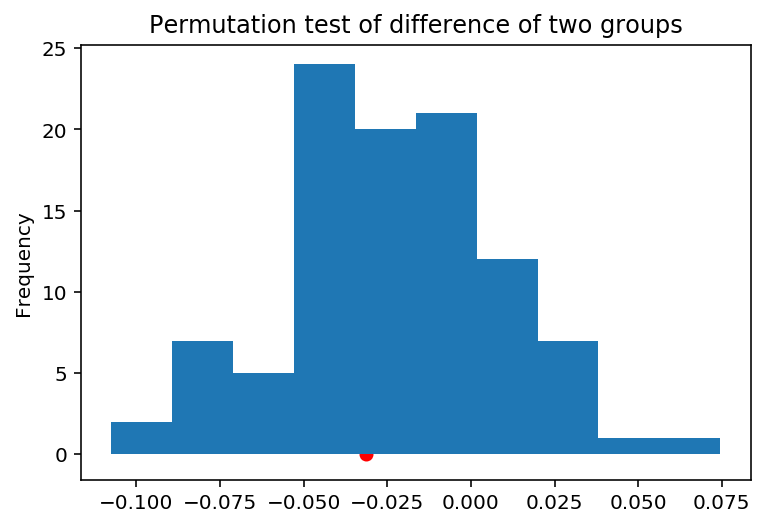

In [88]:
diff_acc_between_two_groups_shuff = (pd.Series(shuffled_2012_2016_score) - pd.Series(shuffled_2000_2011_score))
diff_acc_between_two_groups_shuff.plot(kind = 'hist', title = 'Permutation test of difference of two groups')
plt.scatter(diff_acc_between_two_groups, 0, c = 'r')

In [89]:
(diff_acc_between_two_groups_shuff <= diff_acc_between_two_groups).mean()

0.4

 Fail to reject the model is fair